In [123]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
# Import generic libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.io
import os, sys
import tqdm

In [125]:
# Import local tools
sys.path.append(os.path.expanduser('~/Desktop/Analysis/kohl-lab-pynalysis/'))
from pynalysis import utils

In [126]:
sys.path.append(os.path.expanduser('~/Desktop/Analysis/tensortools-master/'))
import tensortools as tt

In [127]:
# Import local OASIS installation
sys.path.append(os.path.expanduser('~/Desktop/Analysis/OASIS-master/'))
from oasis.functions import gen_data, gen_sinusoidal_data, deconvolve, estimate_parameters
from oasis import oasisAR1, oasisAR2

In [128]:
# Set file-name and path to analyze
stringid = "CGCC8.5a"
# stringid = "AIGC1.1a"
# stringid = "GTRS1.5d"
filename = os.path.expanduser('/Users/mariangelapanniello/Desktop/ca-data-large/2018/%s.mat'%stringid)

In [129]:
# Load data struct
dat = utils.load_mat_file(filename)

Not an old MAT struct. Trying to read as HDF5 for MATLAB v7.3 format instead


In [130]:
# Print contents
print("subject: %s"%stringid)
utils.print_file_content(dat)

subject: CGCC8.5a
imaging/
 date_2018_02_08
 ->area1
  ->plane1
  ->plane2
  ->session_behaviour
 ->area2
  ->plane1
  ->plane2
  ->session_behaviour
 ->area3
  ->plane1
  ->plane2
  ->session_behaviour
 ->area4
  ->plane1
  ->plane2
  ->session_behaviour
 ->area5
  ->plane1
  ->plane2
  ->session_behaviour
 date_2018_02_22
 ->area1
  ->plane1
  ->plane2
  ->session_behaviour
 ->area2
  ->plane1
  ->plane2
  ->session_behaviour
 ->area3
  ->plane1
  ->plane2
  ->session_behaviour


In [131]:
# Select dataset to analyze
area_name = "area1"
expspecifier = "date_2018_02_22/%s"%area_name
path="imaging/%s"%expspecifier
area=dat.get(path)
utils.get_hdf5group_keys(area)

['plane1', 'plane2', 'session_behaviour']

In [132]:
plane1=area['plane1']
plane2=area['plane2']
sessbehav=area['session_behaviour']

In [133]:
# Check how many unit are in each plane
print(plane1['fluoresence_corrected'].shape[1])
print(plane2['fluoresence_corrected'].shape[1])

117
68


In [134]:
print(utils.get_hdf5group_keys(plane1))

['fRate', 'fluoresence_corrected', 'info', 'is_red', 'position', 'raw_fluoresence', 'raw_neuropil', 'spike_amps', 'spike_timings', 'trialByTrialAmps', 'trialByTrialFlu', 'trialByTrialSpikes']


In [135]:
# Extract frame rate from struct
frate = area['plane1/fRate'][0,0]
print("Frame rate %f"%frate)

Frame rate 15.025000


In [136]:
# Merge fluorescence corrected from multiple planes
fluo_raw = np.concatenate([plane1['fluoresence_corrected'], plane2['fluoresence_corrected']],axis=1).T
time = np.arange(len(fluo_raw.T))*1.0/frate

In [137]:
fluo_raw.shape

(185, 14000)

In [138]:
# Select traces below saturation
idx=fluo_raw.max(1)<6000

In [139]:
fluo = fluo_raw[idx]
print(fluo.shape)

(185, 14000)


In [140]:
sample_id = 3
plt.figure(figsize=(16,4))
time = np.arange(len(fluo_raw.T))*1.0/frate
p0 = plt.plot(time, fluo[sample_id].T)
# p0 = plt.plot(time, traces[sample_id].T)
p0=plt.plot(time, np.zeros(time.shape), color='black')
plt.xlabel("Time (s)")
plt.xlim(0,100)
sns.despine()

In [141]:
# Extract positions
tmp = []
for pos in plane1['position']:
    tmp.append(pos)
positions_plane1 = np.array(tmp).T

tmp = []
for pos in plane2['position']:
    tmp.append(pos)
positions_plane2 = np.array(tmp).T

positions_pivot = len(positions_plane1)

In [142]:
print(utils.get_hdf5group_keys(sessbehav))

['ID', 'area', 'date', 'endTTL', 'motor_atOrigin', 'motor_atWhisk', 'motor_back', 'motor_start', 'stim_position', 'stim_speed', 'task', 'velocity']


In [143]:
# Extract event timing
motor_events = ['motor_start', 'motor_back', 'motor_atWhisk']
event_fields = []
event_fields.extend(motor_events)
event_fields.extend(['velocity', 'stim_speed', 'stim_position'])
# event_fields = ['motor_start']

events = {}
for f in event_fields:
    events[f] = np.array(sessbehav[f])
t_stim = events['motor_start']

# discard last event
events['motor_start'] = events['motor_start'][:-1]
events['stim_position'] = events['stim_position'][:-1]
events['stim_speed'] = events['stim_speed'][:-1]

# Preprocessing

In [144]:
events.keys()

dict_keys(['motor_start', 'motor_back', 'motor_atWhisk', 'velocity', 'stim_speed', 'stim_position'])

In [145]:
def plot_trace(groundtruth=False):
    plt.figure(figsize=(20,4))
    plt.subplot(211)
    plt.plot(b+c, lw=2, label='denoised')
    if groundtruth:
        plt.plot(true_b+true_c, c='r', label='truth', zorder=-11)
    plt.plot(y, label='data', zorder=-12, c='y')
    plt.legend(ncol=3, frameon=False, loc=(.02,.85))
    # simpleaxis(plt.gca())
    plt.subplot(212)
    plt.plot(s, lw=2, label='deconvolved', c='g')
    if groundtruth:
        for k in np.where(true_s)[0]:
            plt.plot([k,k],[-.1,1], c='r', zorder=-11, clip_on=False)
    plt.ylim(0,1.3)
    plt.legend(ncol=3, frameon=False, loc=(.02,.85));
    # simpleaxis(plt.gca())
    print("Correlation of deconvolved activity  with ground truth ('spikes') : %.4f" % np.corrcoef(s,true_s)[0,1])
    print("Correlation of denoised fluorescence with ground truth ('calcium'): %.4f" % np.corrcoef(c,true_c)[0,1])

In [146]:
# Init values for OASIS

# tau_d = 270e-3 # GCAMP6M
tau_d = 142e-3 # GCAMP6F

ginit = (np.exp(-1.0/(frate*tau_d)),)
ginit = (None,)
# ginit=(None,) # Single exponential, fit time constant
# ginit = (0.70,) # Single exponential, fix time constant
print(ginit)

(None,)


In [147]:
plt.figure(figsize=(16,4))
p0 = plt.plot(time, fluo.T)
# p1 = plt.scatter(stim.running_forward*1e-3,7*np.ones(len(stim.running_forward)), color='blue', label='Running fwd.')
plt.title("Raw traces")
plt.xlabel("Time (s)")
# plt.ylim(0,1)
sns.despine()

In [148]:
# Run OASIS on each fluorescence trace
traces = []
ret_values = []
for idx in tqdm.trange(len(fluo)):
# for idx in tqdm.trange(10):
    y = np.array(fluo[idx],dtype=float)
    c, s, b, g, lam = r = deconvolve(y, g=ginit, penalty=1)
    traces.append(c)
    # print(g)
    ret_values.append(r)
traces = np.array(traces)

100%|██████████| 185/185 [00:02<00:00, 85.85it/s]


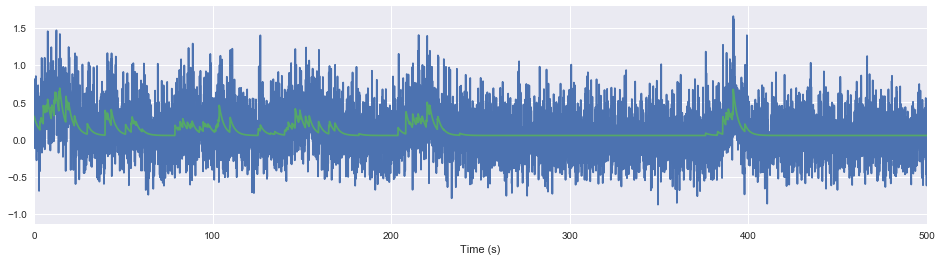

In [149]:
sample_id = 3
smp = ret_values[sample_id]
plt.figure(figsize=(16,4))
p0=plt.plot(time, fluo[sample_id].T)
p0=plt.plot(time, smp[0].T+smp[2])
plt.xlabel("Time (s)")
plt.xlim(0,500)
sns.despine()

In [150]:
plt.figure(figsize=(16,4))
p0 = plt.plot(time, traces.T)
# p1 = plt.scatter(stim.running_forward*1e-3,7*np.ones(len(stim.running_forward)), color='blue', label='Running fwd.')
plt.xlabel("Time (s)")
plt.title("Denoised traces")
sns.despine()

# Sanity checks

##  A look at effective data dimension with PCA

In [151]:
from sklearn.decomposition import PCA, NMF, FastICA
nb_components = 60

In [152]:
X = np.array(traces.T)

pca = PCA()
pca.fit(X)
varexp_denoised = np.cumsum(pca.explained_variance_ratio_)

In [153]:
X = np.array(fluo.T)
time = np.arange(len(X))*1.0/frate
pca = PCA()
pca.fit(X)
varexp_raw = np.cumsum(pca.explained_variance_ratio_)

In [154]:
plt.plot(varexp_raw, label="Raw")
plt.plot(varexp_denoised, label="Denoised")
plt.legend()
plt.xlabel("Num. of components")
plt.ylabel("Variance explained")

## Non-negative matrix factorization

In [155]:
X = np.array(fluo.T-fluo.min())
# X = np.array(fluo_raw.T-fluo_raw.min())
X = np.array(traces.T)
print(X.shape)

(14000, 185)


In [156]:
nb_components = 20
nmf = NMF(n_components=nb_components, random_state=1, alpha=0.1, l1_ratio=0.5)
nmf.fit(X)

NMF(alpha=0.1, beta=1, eta=0.1, init=None, l1_ratio=0.5, max_iter=200,
  n_components=20, nls_max_iter=2000, random_state=1, shuffle=False,
  solver='cd', sparseness=None, tol=0.0001, verbose=0)

In [157]:
# ica = FastICA(n_components=nb_components)
# ica.fit(X)

In [158]:
nmf_tarnsformed = nmf.transform(X)
# nmf_tarnsformed = ica.transform(X)

In [159]:
def plot_events(ev_names, y_offset=1.0, y_scale=0.1):
    cols = ["black", "gray", "darkblue", "darkred", "darkgreen", "blue"]
    for i,label in enumerate(event_fields):
        t_event = events[label]/frate
        y = (y_offset + y_scale*i)*np.ones(t_event.shape)
        plt.scatter(t_event,y,c=cols[i],label=label)

/Users/mariangelapanniello/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


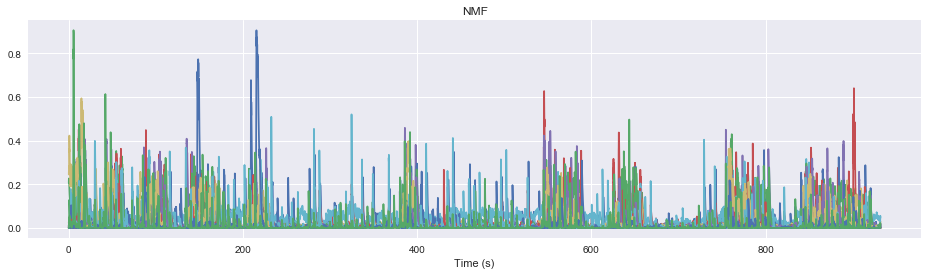

In [160]:
plt.figure(figsize=(16,4))
time = np.arange(len(X))*1.0/frate
p0 = plt.plot(time, nmf_tarnsformed[:,:nb_components])
# plot_events(event_fields)
plt.title("NMF")
plt.xlabel("Time (s)")
plt.legend(loc='best')
sns.despine()

In [161]:
time = np.arange(len(X))*1.0/frate
# plt.plot(time[:-1], events['velocity'].T)

/Users/mariangelapanniello/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


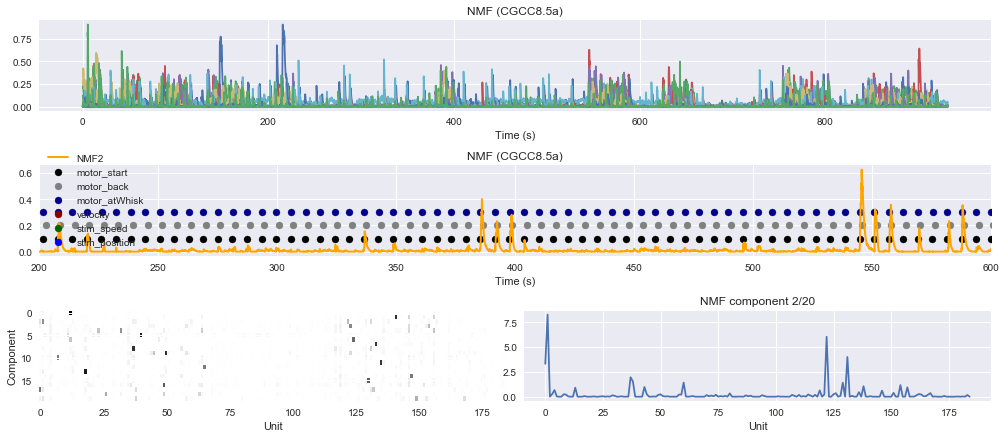

In [162]:
time = np.arange(len(X))*1.0/frate

plt.figure(figsize=(14,6))

plt.subplot(3,1,1)
p0 = plt.plot(time, nmf_tarnsformed[:,:nb_components])
# plot_events(motor_events)
plt.xlabel("Time (s)")
sns.despine()
plt.title("NMF (%s)"%stringid)
plt.legend()
#plt.xlim((200,320))

compid = 2
plt.subplot(3,1,2)
plot_events(motor_events,0.1,0.1)
vel = events['velocity'].ravel()
# p1 = plt.plot(time[:-1],15*vel/vel.max())

p0 = plt.plot(time, nmf_tarnsformed[:,compid], c='orange', linewidth=2, label="NMF%i"%(compid))
plt.xlabel("Time (s)")
sns.despine()
plt.title("NMF (%s)"%stringid)
plt.legend()
plt.xlim((200,600))

plt.subplot(3,2,5)
plt.tight_layout()
plt.imshow(nmf.components_,aspect="auto")
plt.xlabel("Unit")
plt.ylabel("Component")

plt.subplot(3,2,6)
plt.plot(nmf.components_[compid])
plt.xlabel("Unit")
plt.title("NMF component %i/%i"%(compid,nb_components))
sns.despine()

In [163]:
# np.diff((events['motor_start'].ravel()/frate)).mean()

In [164]:
# tuningcurve = os.path.expanduser('/Users/mariangelapanniello/Dropbox/K_lab/Analysis/neuron categories/tuning_data/%stuning.mat' %stringid)
# #tuningcurve = os.path.expanduser('/Users/mariangelapanniello/Dropbox/K_lab/Analysis/ca-data-large/%s.mat'%stringid)

# dat_tuning = utils.load_mat_file(tuningcurve)

# print("subject: %s"%stringid)

# datatuning = dat_tuning['tuning']
# import pprint
# pprint.pprint(datatuning)

# print("tuning/")
# for sess in datatuning:
#     print(" %s"%sess)
#     for area in datatuning[sess]:
#         print(" ->%s"%area)
#         for plane in datatuning[sess][area]:
#             print("  ->%s"%plane)
            
# expspecifier = "date_2018_01_27/area1"
# path="tuning/%s"%expspecifier
# area_tun=dat_tuning.get(path)
# utils.get_hdf5group_keys(area_tun)

# descriptor = "%s/%s"%(stringid,expspecifier)

# plane_1=area_tun['plane1']
# plane_2=area_tun['plane2']

# #print(plane1['categories'])
# #print(plane2['categories'])

# #all_planeOne = plane_1   #necessary?
# #plot_planeOne = all_planeOne['categories']   #necessary?

# plot_planes = [plane_1['categories'], plane_2['categories']]

# plot_planes = np.concatenate(plot_planes,axis=0)
# # print (plot_planes)
# #len(plot_planes)

# ones = np.where(plot_planes==1)[0] #monotonic preference anterior
# twos = np.where(plot_planes==2)[0] #monotonic preference posterior
# threes = np.where(plot_planes==3)[0] #single peaked
# zeroes = np.where(plot_planes==0)[0] #unclassified

# #len(ones)
# #print(ones)

# plt.figure(figsize=(14,4))
# plt.subplot(1,3,1)
# plt.imshow(nmf.components_[:,ones],aspect="auto", cmap='hot')
# plt.xlabel("monotonic neurons")
# plt.ylabel("Component")

# plt.subplot(1,3,2)
# plt.imshow(nmf.components_[:,twos],aspect="auto", cmap='hot')
# plt.xlabel("monotonic neurons")
# plt.ylabel("Component")

# plt.subplot(1,3,3)
# plt.imshow(nmf.components_[:,threes],aspect="auto", cmap='hot')
# plt.xlabel("peaked neurons")
# plt.ylabel("Component")

# plt.figure(figsize=(14,7))
# plt.subplot(2,1,1)
# plt.imshow(nmf.components_[:,threes],aspect="auto", cmap='hot')
# plt.xlabel("unclassified neurons")
# plt.ylabel("Component")

In [165]:
i = 0
vel = -events['velocity'].ravel()
# p1 = plt.plot(time[:-1],15*vel/vel.max())

In [166]:
def reg_scatter(x,y):
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)
    plt.scatter(x,y)
    rx = np.array([x.min(),x.max()])
    ry = intercept+rx*slope
    pl=plt.plot(rx,ry, color='k')
    plt.text(0.66*x.max(), 0.95*y.max(), 'r=%.2f'%(r_value))
    # plt.text(0.66*x.max(), 0.80*y.max(), 'p=%.1e'%(p_value))
    return pl

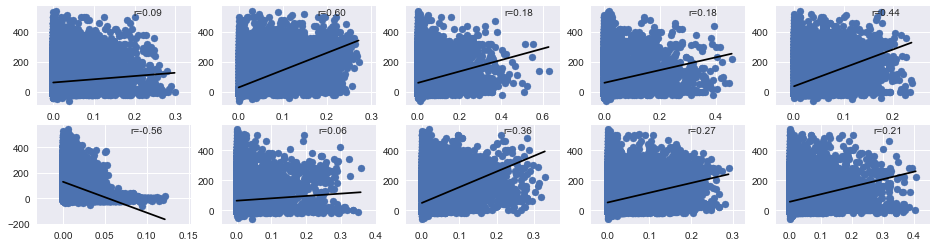

In [167]:
plt.figure(figsize=(16,4))
for i in range(np.min((nb_components,10))):
    plt.subplot(2,5,i+1)
    x, y = nmf_tarnsformed[:-1,i], vel
    reg_scatter(x,y)
sns.despine()

# Trial binning of data

In [168]:
def datamatrix2tensor(data, event_times, toff_after, toff_before=0):
    """ Slices flat data matrix into trial based tensor.
    
    Expects data to be time x unit.
    
    Returns: A tensor which is trial x time x unit.
    """
    trials = []
    nb_frames = data.shape[0]
    for ev in event_times:
        fr = int(ev)
        if fr<toff_before or fr>nb_frames-toff_after: continue
        s = data[fr-toff_before:fr+toff_after]
        trials.append(s)
    return np.array(trials)

In [169]:
def tensorbin(data, bin_size=10):
    """ Takes data tensor and bins it """
    nb_bins = data.shape[1]//bin_size
    #print(data.shape)
    binned = []
    for i in range(nb_bins):
        a = data[:,i*bin_size:(i+1)*bin_size,:]
        # print(a.shape)
        binned.append(np.sum(a,axis=1))
    return np.transpose(np.array(binned),axes=[1,0,2])
    
def bin_data(data, event_times, toff_after=60, toff_before=0, bin_size=10, axis=1):
    datatensor = datamatrix2tensor(data,event_times,toff_before=toff_before, toff_after=toff_after)
    #     return datatensor.mean(axis=axis)
    return tensorbin(datatensor, bin_size)

# Decoding stimulus from neural data using SVM Classifier

In [170]:
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [171]:
def split_dataset(dataset, split=0.8):
    x,y = dataset
    n = len(x)
    s = int(split*n)
    idx = np.arange(len(x))
    np.random.shuffle(idx)
    x = x[idx]
    y = y[idx]
    x_train = x[:s]
    x_valid = x[s:]
    y_train = y[:s]
    y_valid = y[s:]
    return (x_train, y_train),(x_valid, y_valid)

In [172]:
def fuse_dataset(data, labels):
    d = data.reshape((data.shape[0],-1))
    return d,labels

In [173]:
def get_acc(dataset):
    pred=svc.predict(dataset[0])
    acc=(pred==dataset[1]).mean()
    return acc

In [174]:
def get_acc_all_times(all_data, labels, units="all", kernel="linear"):
    """ Fits SVC on each time slice from datatensor
    
    Args:
    all_data : Expects datatensor with trials x time x unit. 
    labels : The labels for training the classifier.
    units : A list of indices of units to include in the analysis or "all" for all (default "all").
    kernel : The kernel to use for the classifier.
    
    Returns classification accuracy scores for 5-fold CV of a linear classifer.
    """
    if units=="all":
        data_selection = all_data
    else:
        data_selection = all_data[:,:,units]
       
    dataset = fuse_dataset(data_selection,labels)
    clf = SVC(kernel=kernel, C=1)
    scores = cross_val_score(clf, dataset[0], dataset[1], cv=5)
    return scores

def scan_acc_time(all_data, labels, units="all", kernel="linear"):
    """ Fits SVC on each time slice from datatensor
    
    Args:
    all_data : Expects datatensor with trials x time x unit. 
    labels : The labels for training the classifier.
    units : A list of indices of units to include in the analysis or "all" for all (default "all").
    kernel : The kernel to use for the classifier.
    
    Returns classification accuracy scores for 5-fold CV of a linear classifer over time.
    """
    if units=="all":
        data_selection = all_data
    else:
        data_selection = all_data[:,:,units]
       
    results = []
    for t in range(data_selection.shape[1]):
        partial_data = data_selection[:,t,:]
        dataset = fuse_dataset(partial_data,labels)
        clf = SVC(kernel=kernel, C=1)
        scores = cross_val_score(clf, dataset[0], dataset[1], cv=5)
        results.append(scores)
    results = np.array(results)
    return results

In [177]:
# How many frames before and after the onset signal we use for classification
frames_before = 15
frames_after  = 75

# Create data tensor from denoised traces for all trials
full_data = datamatrix2tensor(traces.T, events['motor_atWhisk'], toff_before=frames_before, toff_after=frames_after)
print("Datatensor shape: ",full_data.shape)

# Creat labels for data
labels = stim_pos = events['stim_position'].ravel()
print("Unique labels: ",np.unique(labels))
len(labels)

Datatensor shape:  (151, 90, 185)
Unique labels:  [ 45.  53.  61.  69.]


150

In [176]:
# Compute classification accuracy for each time bin
results = scan_acc_time(full_data, labels)
# Compute classification accuracy for all time bins together
acc_total = get_acc_all_times(full_data, labels)

ValueError: Found input variables with inconsistent numbers of samples: [151, 150]

In [ ]:
x = np.linspace(-frames_before/frate,frames_after/frate,full_data.shape[1])
def plot_res(x, results, label=None):
    means = results.mean(1)
    stdev = results.std(1)
    return plt.errorbar(x, means, yerr=stdev, label=label)
plot_res(x, results)
m,s=acc_total.mean(),acc_total.std()
plt.plot([x[0], x[-1]], [m, m], color='gray', linestyle='--', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Accuracy')
sns.despine()

In [ ]:
# Do the same analysis for each plane separately
nb_plane1 = plane1['fluoresence_corrected'].shape[1]
nb_plane2 = plane2['fluoresence_corrected'].shape[1]
results1 = scan_acc_time(full_data, labels, units=range(nb_plane1))
results2 = scan_acc_time(full_data, labels, units=range(nb_plane1,nb_plane1+nb_plane2))

In [ ]:
plot_res(x, results1, label="Plane 1")
plot_res(x, results2, label="Plane 2")
m,s=acc_total.mean(),acc_total.std()
plt.plot([x[0], x[-1]], [m, m], color='gray', linestyle='--', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Accuracy')
plt.legend()
sns.despine()

In [ ]:
# Run the classifyer only on units 0,1,2,3 and 50..99
units = [0,1,2,3] + list(range(50,100))
results = scan_acc_time(full_data, labels, units=units)
# Compute classification accuracy for all time bins together
acc_total = get_acc_all_times(full_data, labels, units=units)

In [ ]:
plot_res(x, results)
m,s=acc_total.mean(),acc_total.std()
plt.plot([x[0], x[-1]], [m, m], color='gray', linestyle='--', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Accuracy')
sns.despine()